# CMB CONVERGENCE ANGULAR POWER SPECTRA

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d

In [22]:
from astropy.cosmology import FlatLambdaCDM
cosmo = FlatLambdaCDM(H0=67.5, Ob0=0.0483, Om0= 0.2678)

## 1. Matter power spectra

In [2]:
import sys
sys.path.append("../power/EdS")
from matter import matter_power_spectrum_1loop as P1loop
from matter import matter_unequal_time_power_spectrum as Puetc
sys.path.append("../analysis")
from power import geometric_approx_squared as PPgeom
from power import midpoint_approx as Pmid

* Linear power spectra

Use SkyPy here

In [3]:
import camb

In [4]:
nz = 100

pars = camb.CAMBparams()
pars.set_cosmology(H0=67.5, ombh2=0.022, omch2=0.122)
pars.InitPower.set_params(ns=0.965)

results = camb.get_background(pars)
xs = results.conformal_time(0) - results.tau_maxvis
x = np.linspace(0, xs, nz)
z = results.redshift_at_comoving_radial_distance(x)
k = np.logspace(-5, 3, 1024)

kh = k/(pars.H0/100)
pars.set_matter_power(redshifts=z, kmax=2*k[-1], nonlinear=True)
results = camb.get_results(pars)
kh, z, p = results.get_matter_power_spectrum(minkh=kh[0], maxkh=kh[-1], npoints=len(kh))

Note: redshifts have been re-sorted (earliest first)


In [5]:
pars.set_for_lmax(50000, lens_potential_accuracy=2)
pars.min_l = 1
results = camb.get_results(pars)
cl_camb = results.get_lens_potential_cls(50000)[:,0]

In [6]:
np.allclose(kh*(pars.H0/100), k)

True

* Unequal-time power spectra

In [7]:
pgeom_linear = np.sqrt(p[:, None] * p[None, :])

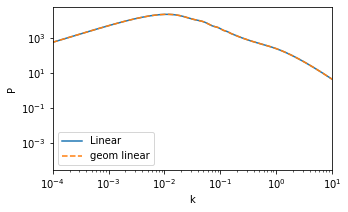

In [8]:
plt.figure(figsize=(5,3))
plt.loglog(k, p[0], label='Linear')
plt.loglog(k, pgeom_linear[0][0], '--', label='geom linear')

plt.xlabel('k')
plt.ylabel('P')
plt.xlim(1e-4, 1e1)
plt.legend()
plt.show()

## 2. The correlation function

In [9]:
sys.path.append("../../corfu")
import corfu

In [10]:
theta = np.logspace(-3, np.log10(np.pi), 400)

In [11]:
r_limb_linear, xi_limb_linear = corfu.ptoxi(k, p, q=0.432, limber=True)
r_geom_linear, xi_geom_linear = corfu.ptoxi(k, pgeom_linear, q=0.737)

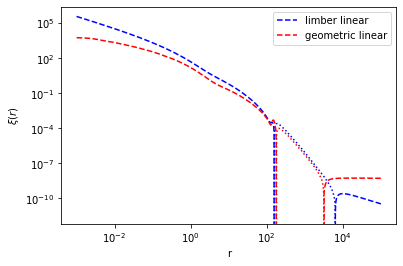

In [12]:
plt.loglog(r_limb_linear, +xi_limb_linear[0], '--b', label='limber linear')
plt.loglog(r_limb_linear, -xi_limb_linear[0], ':b')
plt.loglog(r_geom_linear, +xi_geom_linear[0,0], '--r', label='geometric linear')
plt.loglog(r_geom_linear, -xi_geom_linear[0,0], ':r')

plt.legend()
plt.xlabel('r')
plt.ylabel(r'$\xi(r)$')
plt.show()

## 3. Lensing filters

In [13]:
sys.path.append("../lensing")
from lens_filter import redshift_distribution_galaxies, filter_galaxy_clustering, lensing_efficiency, lensing_efficiency_cmb, filter_convergence, filter_shear

In [14]:
chi = np.linspace(0., xs, 1200)
zchi = results.redshift_at_comoving_radial_distance(chi)

* Lensing efficiency

In [15]:
q = lensing_efficiency_cmb(chi, xs)

* Convergence

In [23]:
f = filter_convergence(chi, zchi, q, cosmo)

## 4. Angular correlation function

* Convergence

In [24]:
w_limb_linear = corfu.eqt(theta, (chi, f*f), (x, r_limb_linear, xi_limb_linear))
w_geom_linear = corfu.uneqt(theta, (chi, f), (chi, f), (x, x, r_geom_linear, xi_geom_linear))

In [25]:
w_camb = corfu.cltow(cl_camb, theta)

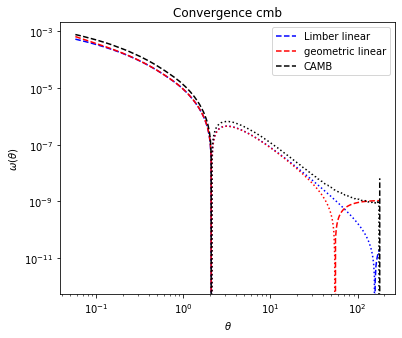

In [26]:
plt.figure(figsize=(6, 5))
plt.loglog(np.degrees(theta), +w_limb_linear, '--b', label='Limber linear')
plt.loglog(np.degrees(theta), -w_limb_linear, ':b')
plt.loglog(np.degrees(theta), +w_geom_linear, '--r', label='geometric linear')
plt.loglog(np.degrees(theta), -w_geom_linear, ':r')
plt.loglog(np.degrees(theta), +0.5*w_camb, '--k', label='CAMB')
plt.loglog(np.degrees(theta), -0.5*w_camb, ':k')


plt.legend()
plt.xlabel(r'$\theta$')
plt.ylabel(r'$\omega(\theta)$')
plt.title('Convergence cmb')
# plt.savefig('../plots/convergence_w.pdf')
plt.show()

## 5. Angular power spectra

* Convergence

In [27]:
l_limb_linear, cl_limb_linear = corfu.wtocl(theta, w_limb_linear, lmax=2000)
l_geom_linear, cl_geom_linear = corfu.wtocl(theta, w_geom_linear, lmax=2000)

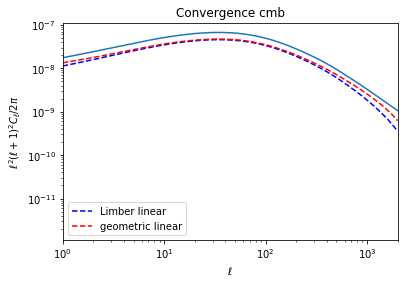

In [28]:
plt.loglog(cl_limb_linear, '--b', label='Limber linear')
plt.loglog(cl_geom_linear, '--r', label='geometric linear')
plt.loglog(0.5*cl_camb)

plt.legend()
plt.xlabel(r'$\ell$')
plt.ylabel(r'$\ell^2(\ell+1)^2C_\ell/2\pi$')
plt.xlim([1,2000])
plt.title('Convergence cmb')
# plt.savefig('../plots/convergence_cl.pdf')
plt.show()